In [1]:
'''
torch for general PyTorch functionality
torch.nn and torch.nn.functional for neural network based functions
torch.optim for our optimizer which will update the parameters of our neural network
torch.utils.data for handling the dataset
torchvision.transforms for data augmentation
torchvision.datasets for loading the dataset
sklearn's metrics for visualizing a confusion matrix
sklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions
matplotlib for plotting 
'''

"\ntorch for general PyTorch functionality\ntorch.nn and torch.nn.functional for neural network based functions\ntorch.optim for our optimizer which will update the parameters of our neural network\ntorch.utils.data for handling the dataset\ntorchvision.transforms for data augmentation\ntorchvision.datasets for loading the dataset\nsklearn's metrics for visualizing a confusion matrix\nsklearn's decomposition and manifold for visualizing the neural network's representations in two dimensions\nmatplotlib for plotting \n"

In [2]:

#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#%pip install tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time



In [3]:
SEED = 4345 #for reproducible results 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
#Loading the data set from MNIST [torchvison]
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

In [5]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [6]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [7]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [8]:
#loading data with defined transforms 
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [10]:
#displays images in grid format 
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

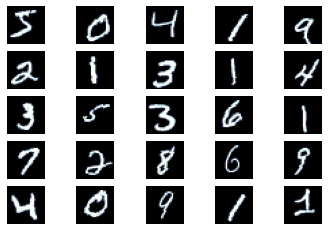

In [11]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [12]:
#creating validation set to be 10% of traindata
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples


In [13]:
#split into train and validation data
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [14]:

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


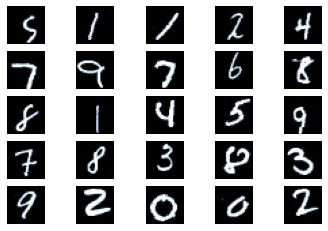

In [15]:
N_IMAGES = 25

images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [16]:
#made the validation set a deep opy so it isnt still referencing train data, need to remove tranfoms to act as proxy test set
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

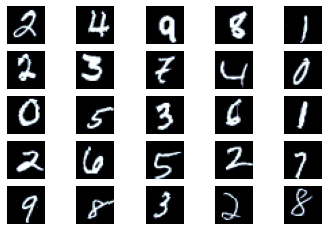

In [17]:
#displaying sample set of training data
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [18]:
#dataloader uses batches to load data
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [19]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [20]:
'''
The init fucntion contains the input layer which takes in 784 dimensional vector and condenses it to 250
The hidden layer condesnes it to 100 features
The output feature condeses to 10
'''

'\nThe init fucntion contains the input layer which takes in 784 dimensional vector and condenses it to 250\nThe hidden layer condesnes it to 100 features\nThe output feature condeses to 10\n'

In [21]:
# input = number of pixels in data output = digits 0-9
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
'''count of trainable parameters '''

'count of trainable parameters '

In [24]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


In [25]:
'''The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.

The second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.

The third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

'''

'The first layer has 784 neurons connected to 250 neurons, so 784*250 weighted connections plus 250 bias terms.\n\nThe second layer has 250 neurons connected to 100 neurons, 250*100 weighted connections plus 100 bias terms.\n\nThe third layer has 100 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.\n\n'

In [26]:
optimizer = optim.Adam(model.parameters())

In [27]:
criterion = nn.CrossEntropyLoss()


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# places model and data on cpu

In [29]:
model = model.to(device)
criterion = criterion.to(device)

In [30]:
# calculates accuracy by tasking highest probability choice assigned by model and compares it to class label 
# divide correct choices by total amt to get it 
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [31]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
#function tells how long an epoch lasts 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
#in each epoch, we calculate training loss and accuracy, validation loss, and acccuracy
# if its the best validation score received, we save the params 
#%pip install ipywidgets widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 0.400 | Train Acc: 87.55%
	 Val. Loss: 0.134 |  Val. Acc: 95.98%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 0.167 | Train Acc: 94.91%
	 Val. Loss: 0.121 |  Val. Acc: 96.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 56s
	Train Loss: 0.136 | Train Acc: 95.98%
	 Val. Loss: 0.099 |  Val. Acc: 96.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 59s
	Train Loss: 0.115 | Train Acc: 96.46%
	 Val. Loss: 0.096 |  Val. Acc: 96.88%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 58s
	Train Loss: 0.106 | Train Acc: 96.68%
	 Val. Loss: 0.074 |  Val. Acc: 97.41%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 59s
	Train Loss: 0.101 | Train Acc: 96.89%
	 Val. Loss: 0.083 |  Val. Acc: 97.38%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 1s
	Train Loss: 0.093 | Train Acc: 97.11%
	 Val. Loss: 0.074 |  Val. Acc: 97.65%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 2s
	Train Loss: 0.086 | Train Acc: 97.32%
	 Val. Loss: 0.063 |  Val. Acc: 97.83%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 4s
	Train Loss: 0.081 | Train Acc: 97.42%
	 Val. Loss: 0.063 |  Val. Acc: 97.82%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 2s
	Train Loss: 0.079 | Train Acc: 97.45%
	 Val. Loss: 0.056 |  Val. Acc: 98.14%


In [35]:
# After training for a while, we save our most accurate model state and use it to test on the test set

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

In [36]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.048 | Test Acc: 98.52%


In [37]:
#this function returns the model prediction over a dataset ( the model image input, output prediction, and the ground truth label)
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [38]:
#gets prediction by taking highest probability index
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [39]:
#make a confusion matrix from actual and predited labels 
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

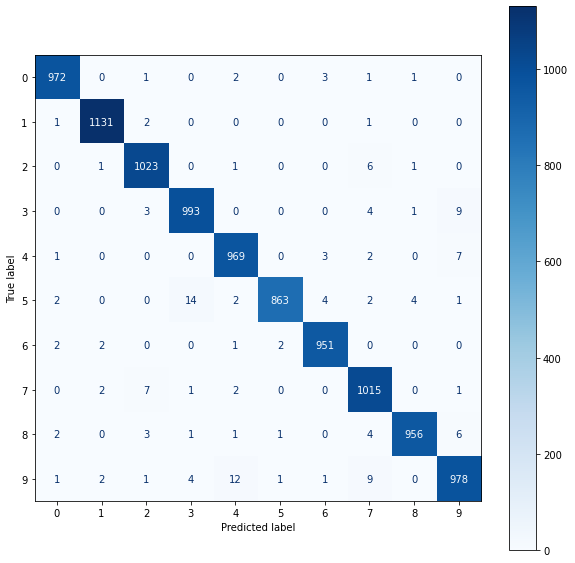

In [40]:
plot_confusion_matrix(labels, pred_labels)

In [41]:
# The most confused numbers are 4-9 and 3-5

In [42]:
#Checking if predicted labels match ground truth 
corrects = torch.eq(labels, pred_labels)

In [43]:
#store all incorrect examples in an array and store based on how confidentr model was on the pick
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [45]:
#plot based on how confident model was in pick versus confidence in correct choice
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

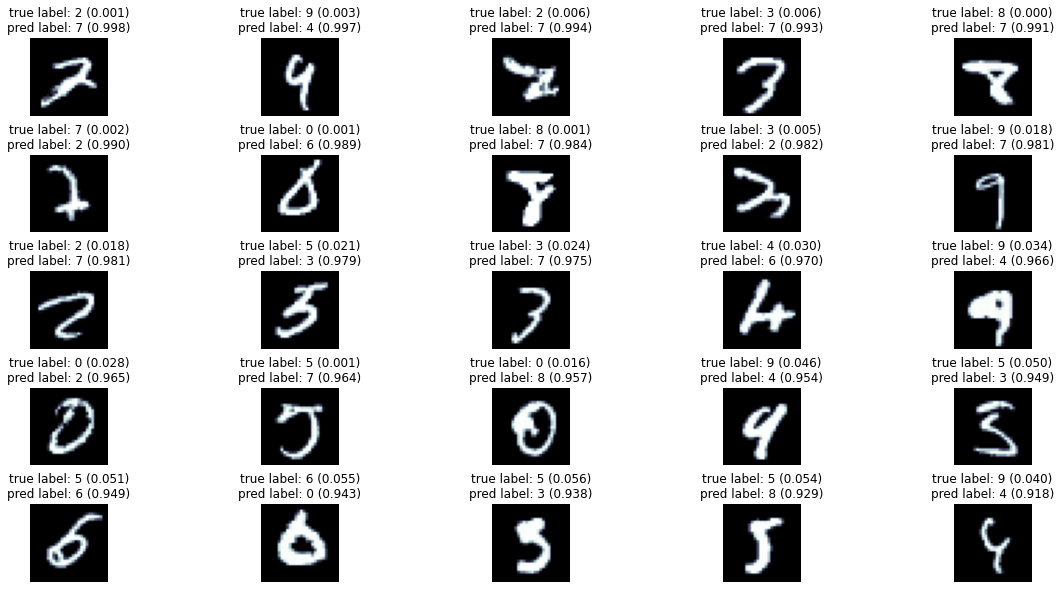

In [46]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [47]:
#one pattern that emerges from this is that there are irregular digits so its hard for the model to perform well there
#another is that there are digits that are confused based on subtle differences (you can see where it went wrong)

#The model hasn't been trained to be non-confident. It's guesses aren't evenly distributed if it isn't sure, it has only learned to guess one answer confidently


In [48]:
#We can also get the representation of the output layer guess from the previous layer
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [49]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

In [50]:
#To graph the 100 and 10 dimension layers, we need to push it down to 2 dimensions for plotting
#We can use principal component analysis to do this 
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

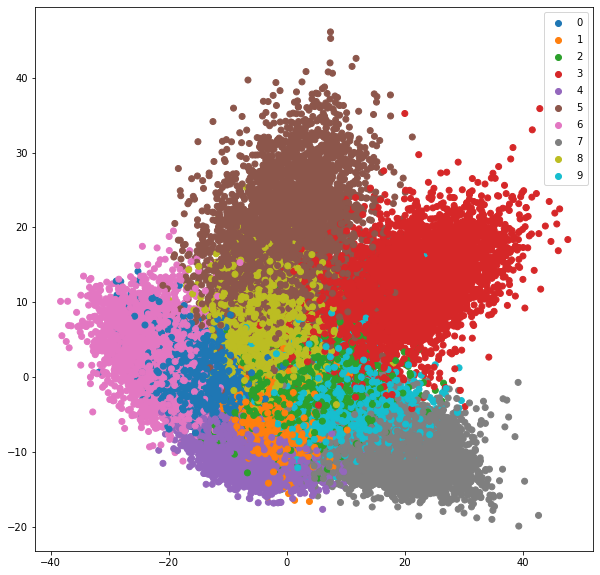

In [51]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

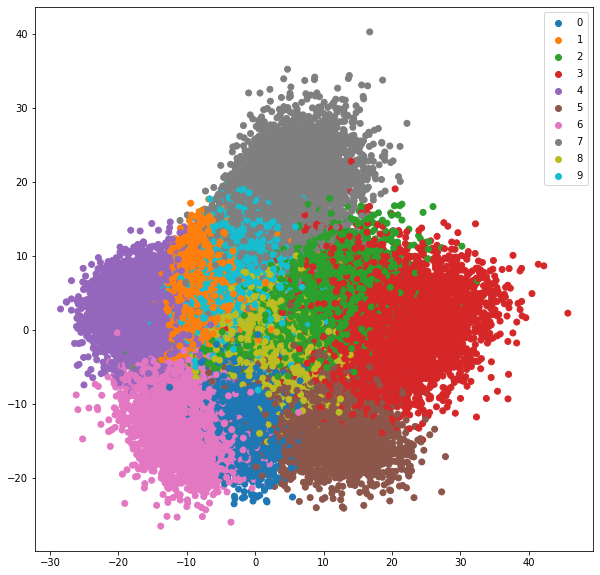

In [52]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

In [53]:
# The graphs of the output and 2n hidden layer share similarities 


In [54]:
#we can also use t-sne instead of PCA, but it is very slow
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

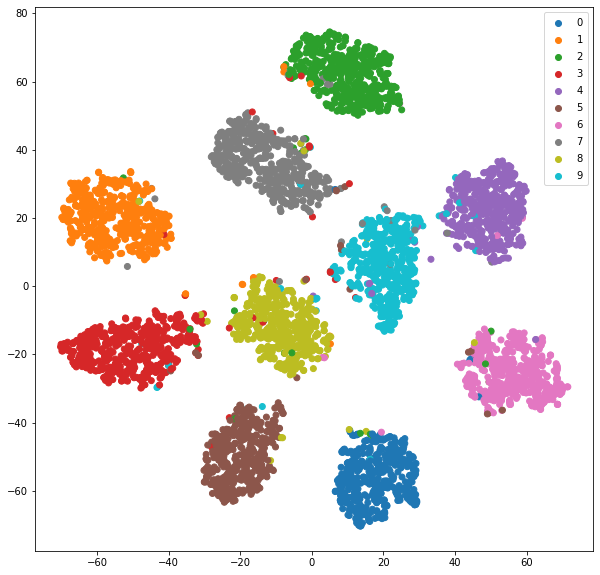

In [55]:
#we use a subset of the images for classification
N_IMAGES = 5_000

#the output classifications seem pretty well searated 
#this maes sense because the theory is that the model will id patterns to spearate its choices
#each layer adds another filter to separate these custers more and more
output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

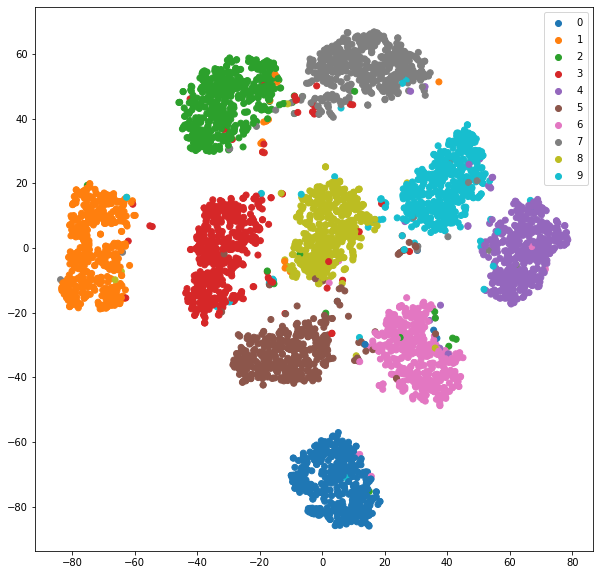

In [57]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

In [58]:
#With a lower intermediate layer, the clusters are a little closer

In [60]:
#We can also generate a fake digit
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [61]:
#function generates random noise, here we try to see if it guesses 3
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [62]:
#guess of model 
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 100.00%


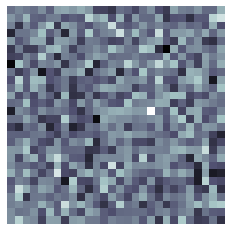

In [63]:
plt.imshow(best_image.cpu().numpy(), cmap='bone')
plt.axis('off');

In [64]:
#unfortunately, the image is random noise. The model guessed its a 3 confidently, because it was trained to make
#confident assumptions. when faced with random noise will try and classify it as something
# also possible that the model is overfitting on the training set - that there is a common pattern in handwritten threes within the training set, but it's not the pattern we want our model to learn

In [65]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

In [66]:
#we can plot the weights in the first layer of our model
#By plotting a neuron's weights, you can visualize the data patterns it's trained to detect and look for


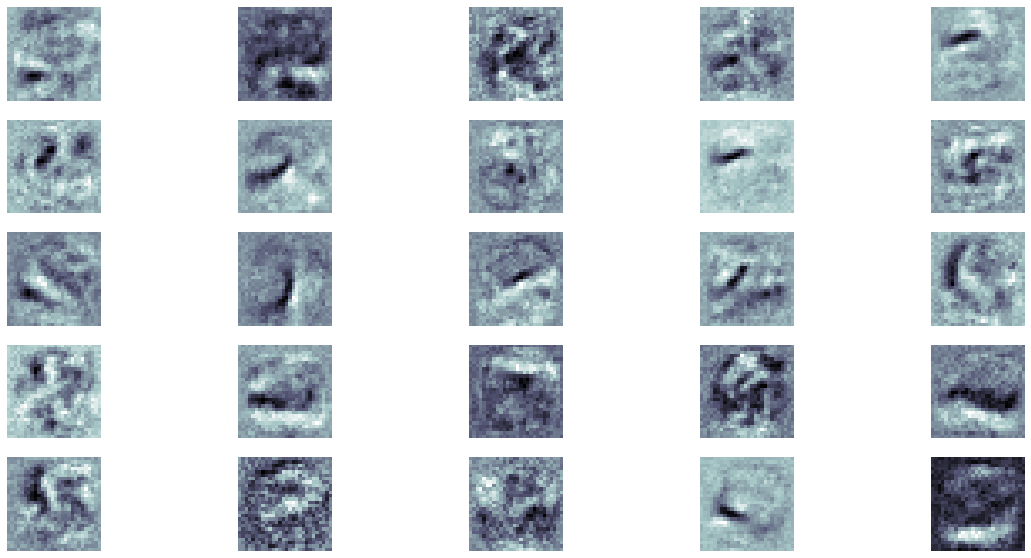

In [67]:
N_WEIGHTS = 25

weights = model.input_fc.weight.data

plot_weights(weights, N_WEIGHTS)

In [ ]:
#plotting the weights hsows that the model neurons are learning to weigh certain pixels for digits 

#In this notebook we have shown:

#loading Torchvision datasets
#loading transforms to augment and normalize our data
#defining a MLP
#training a model to achieve >97% accuracy
#viewing our model's mistakes
#visualizing our data in lower dimensions with PCA and t-SNE
#generating fake digits
#viewing the learned weights of our model